# COVID-19 integration with PBMC and HCL atlases

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import scarches as sca
import scanpy as sc

Using TensorFlow backend.


In [3]:
sc.settings.set_figure_params(dpi=100, frameon=False)

In [4]:
study_key = "study"
cell_type_key = "celltype"

In [5]:
query_studies = ['COVID-19 (query)']

## Load data

In [8]:
adata = sca.data.read("/home/mohsen/data/covid_lisa/covid_for_publish_normalized_5k.h5ad")

In [14]:
reference_adata = adata[~adata.obs[study_key].isin(query_studies)]

In [15]:
query_adata = adata[adata.obs[study_key].isin(query_studies)]

In [16]:
n_studies = len(reference_adata.obs[study_key].unique().tolist())
n_studies

17

## create scNetNB object

In [25]:
network = sn.models.scNet(task_name='COVID_new_reference',
                            x_dimension=reference_adata.shape[1], 
                            z_dimension=10,
                            architecture=[128,128],
                            n_conditions=n_studies,
                            use_batchnorm=True,
                            alpha=0.0002,
                            clip_value=3,
                          size_factor_key="scale_factors",
                            loss_fn = "nb",
                            model_path="./models/scNetNB_new_publish_2/",
                            dropout_rate=0.1)

scNetNB's network has been successfully constructed!
scNetNB's network has been successfully compiled!


In [26]:
network.train(reference_adata,
              train_size=0.90, 
              condition_key=study_key,
              n_epochs=120,
              early_stop_limit=10,
              batch_size=512, 
              save=True,
              retrain=True)

 |████████████████████| 100.0%  - loss: 0.3352 - kl: 5.0369 - nb: 0.3342 - val_loss: 0.3256 - val_kl: 4.8393 - val_nb: 0.3247

scNetNB has been successfully saved in ./models/scNetNB_new_publish_2/COVID_new_reference.


In [27]:
plot_adata = sc.pp.subsample(reference_adata, n_obs=20000, copy=True)

In [28]:
latent_adata = network.get_latent(plot_adata, study_key)

In [29]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

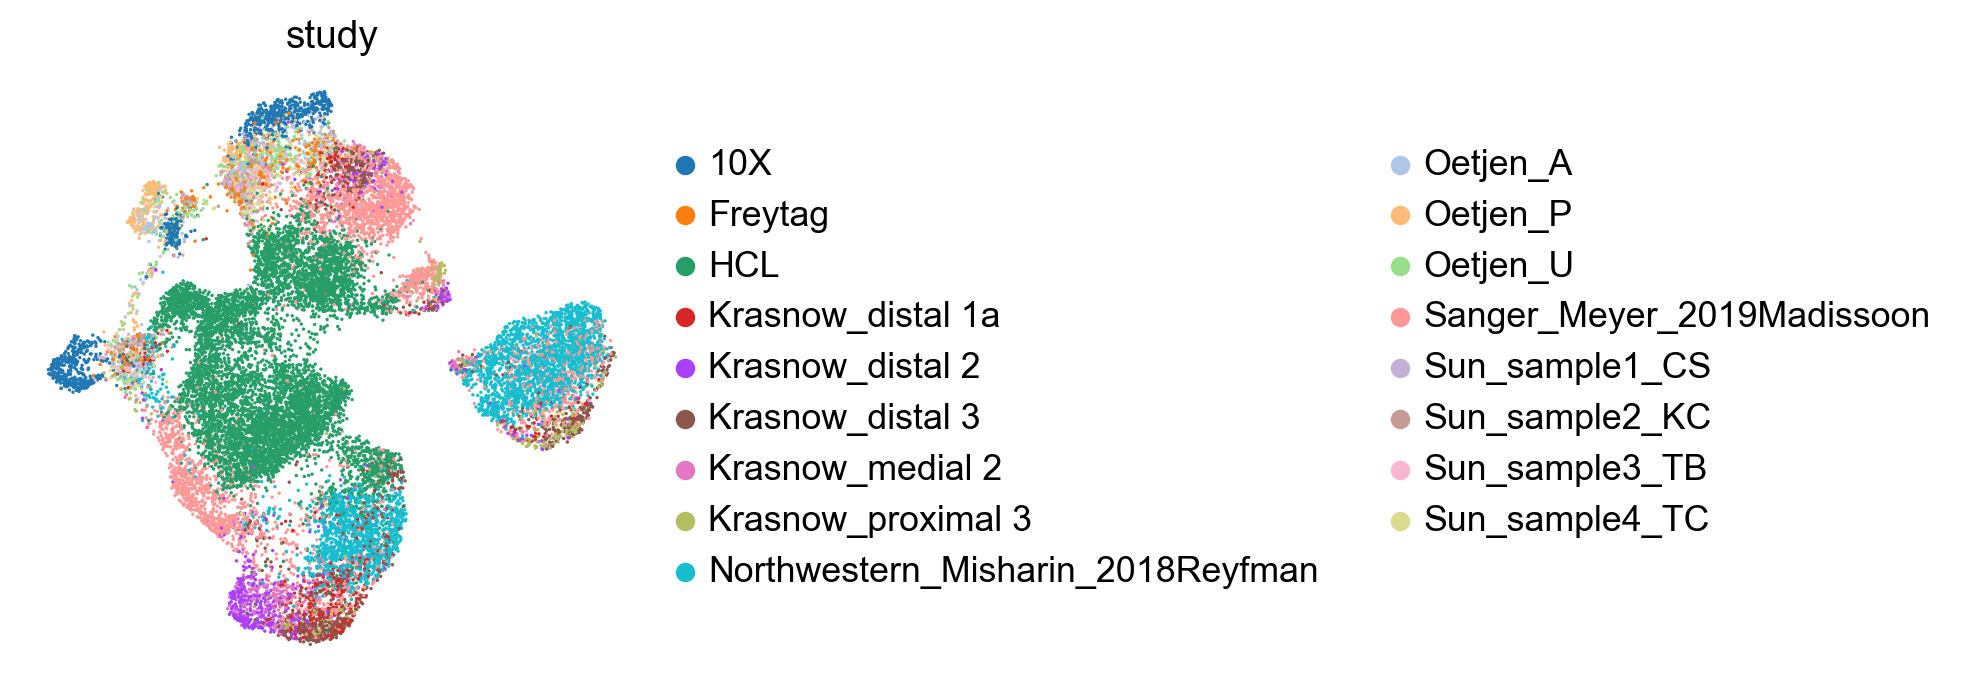

In [30]:
sc.pl.umap(latent_adata, color=[study_key], frameon=False)

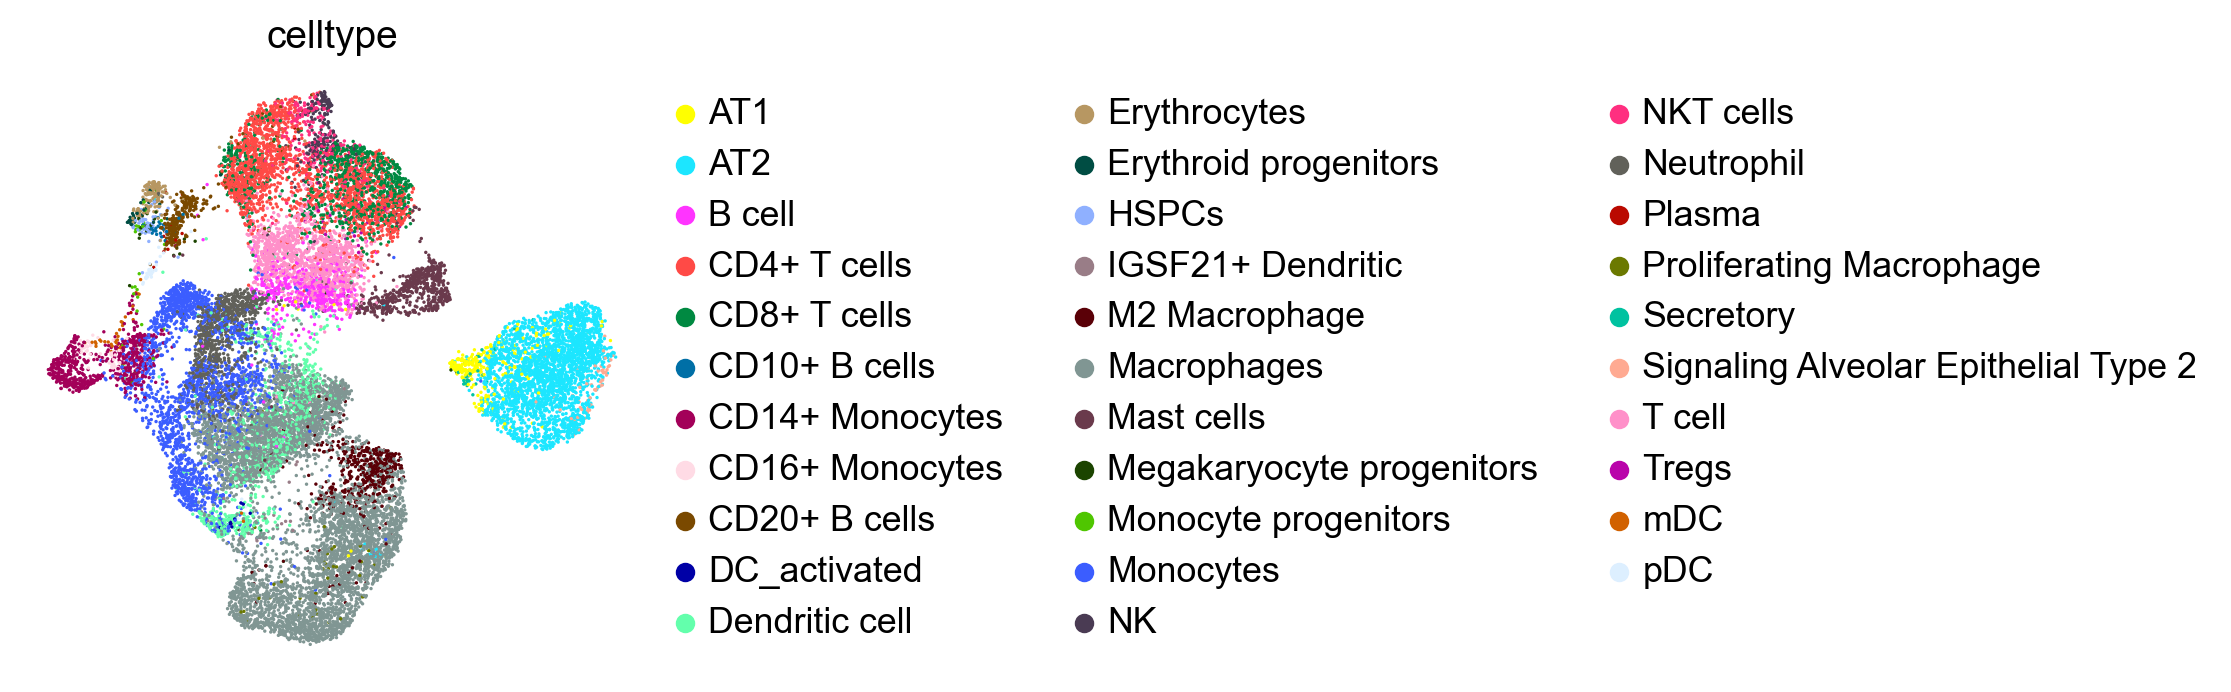

In [31]:
sc.pl.umap(latent_adata, color=[cell_type_key], frameon=False)

In [32]:
new_network = sn.operate(network, 
                         new_task_name='COVID_new_query',
                         new_conditions=query_studies,
                         version='scNet')

scNetNB's network has been successfully constructed!
scNetNB's network has been successfully compiled!
scNetNB's network has been successfully compiled!


In [33]:
new_network.train(query_adata,
                  train_size=0.95, 
                  condition_key=study_key,
                  n_epochs=100,
                  early_stop_limit=10,
                  batch_size=512, 
                  save=True,
                  lr_reducer=100,
                  retrain=True)

 |██------------------| 13.0%  - loss: 0.5613 - kl: 5.0496 - nb: 0.5603 - val_loss: 0.5605 - val_kl: 5.0525 - val_nb: 0.5595
scNetNB has been successfully saved in ./models/scNetNB_new_publish_2/COVID_new_query.


In [34]:
plot_adata = sc.pp.subsample(adata, n_obs=10000, copy=True)

In [35]:
latent_adata = new_network.get_latent(plot_adata, study_key)
latent_adata

AnnData object with n_obs × n_vars = 10000 × 10
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue', 'scale_factors'

In [36]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

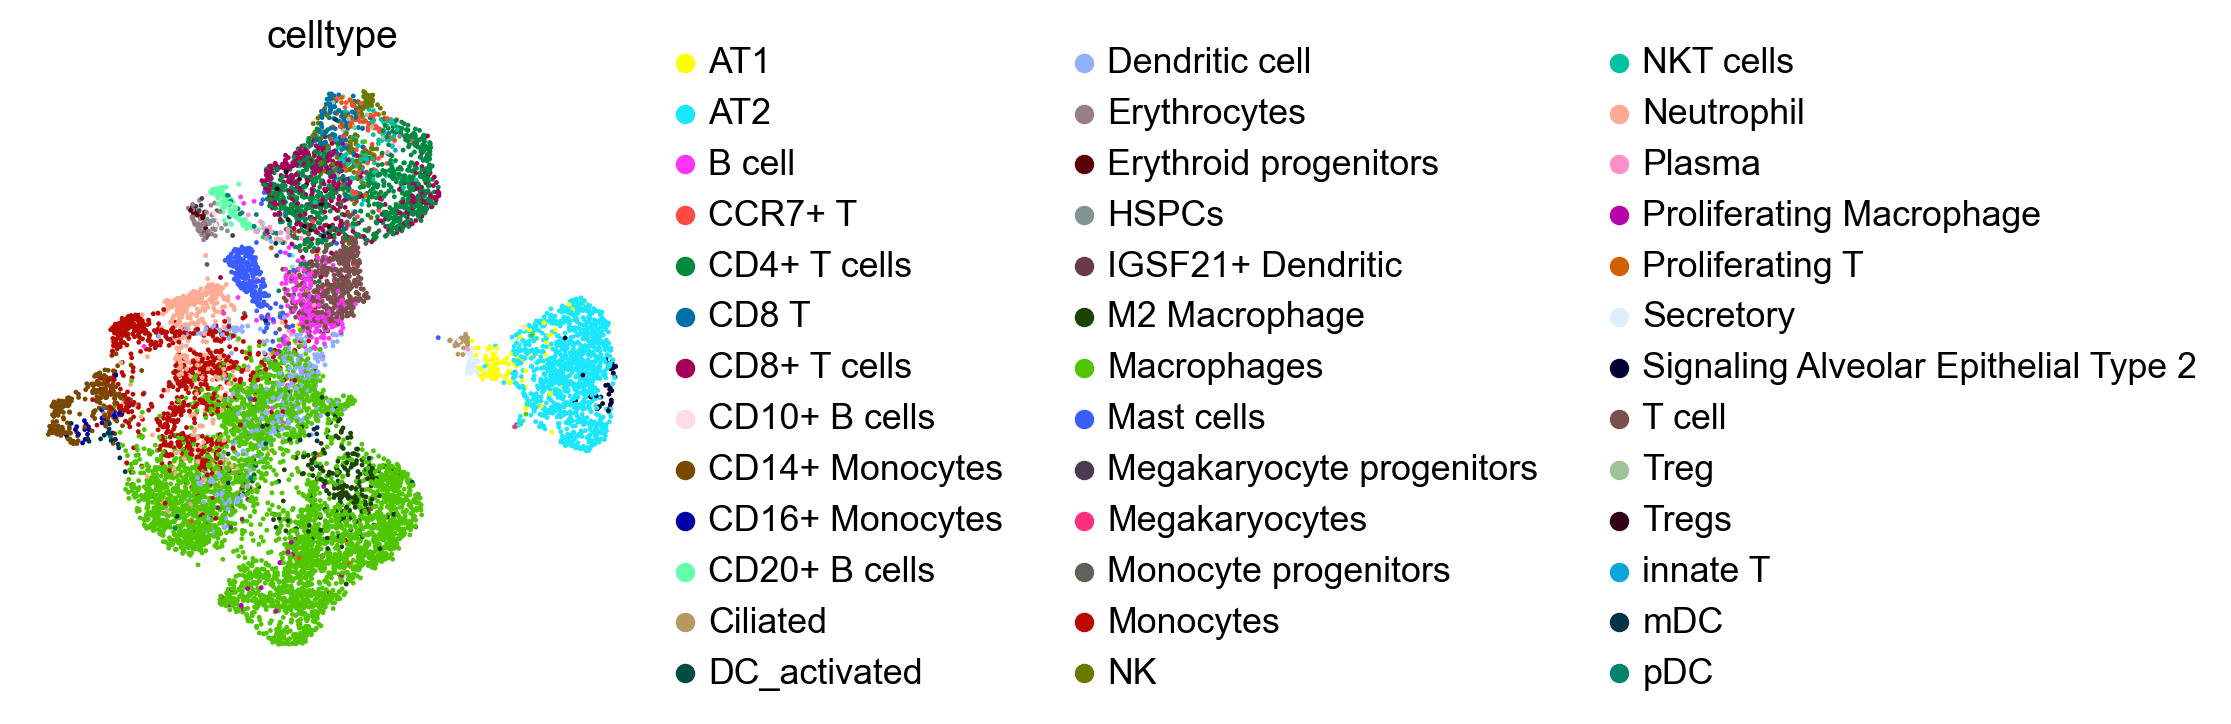

In [37]:
sc.pl.umap(latent_adata, color=[cell_type_key], palette=sc.pl.palettes.godsnot_102, frameon=False)

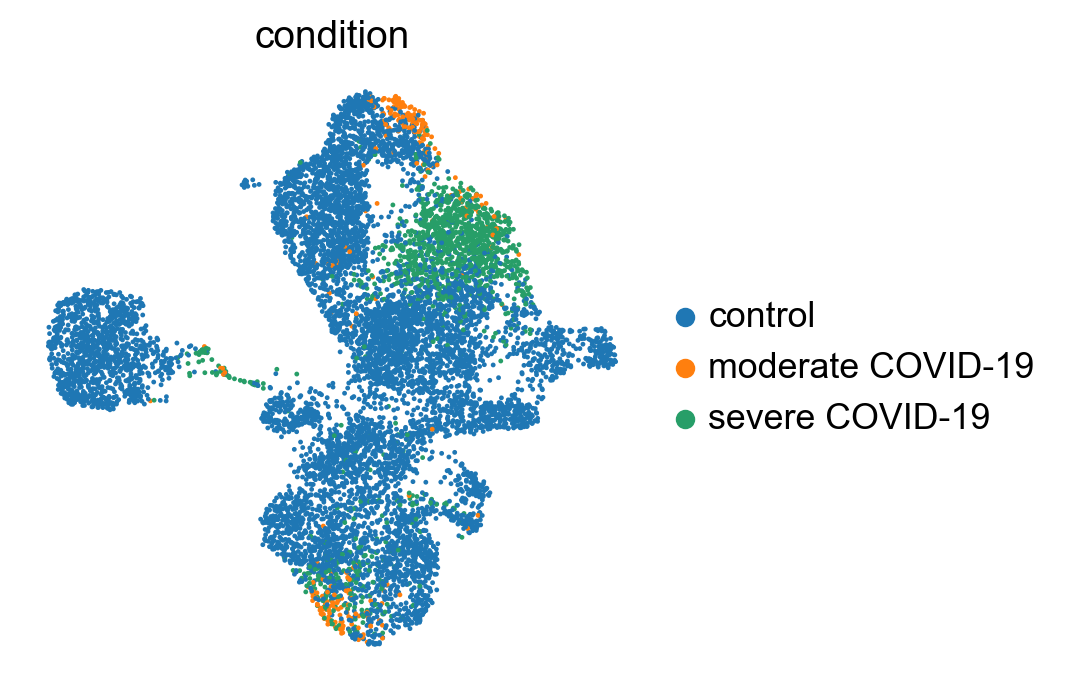

In [53]:
sc.pl.umap(latent_adata, color=["condition"], frameon=False)

In [38]:
latent_adata = new_network.get_latent(adata, study_key)
latent_adata

AnnData object with n_obs × n_vars = 274346 × 10
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue', 'scale_factors'

In [39]:
adata = sn.data.read("./data/covid/covid_for_publish.h5ad")

In [40]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [41]:
adata.obsm["latent"] = latent_adata.X

In [42]:
adata.obsm["X_umap"] = latent_adata.obsm["X_umap"]

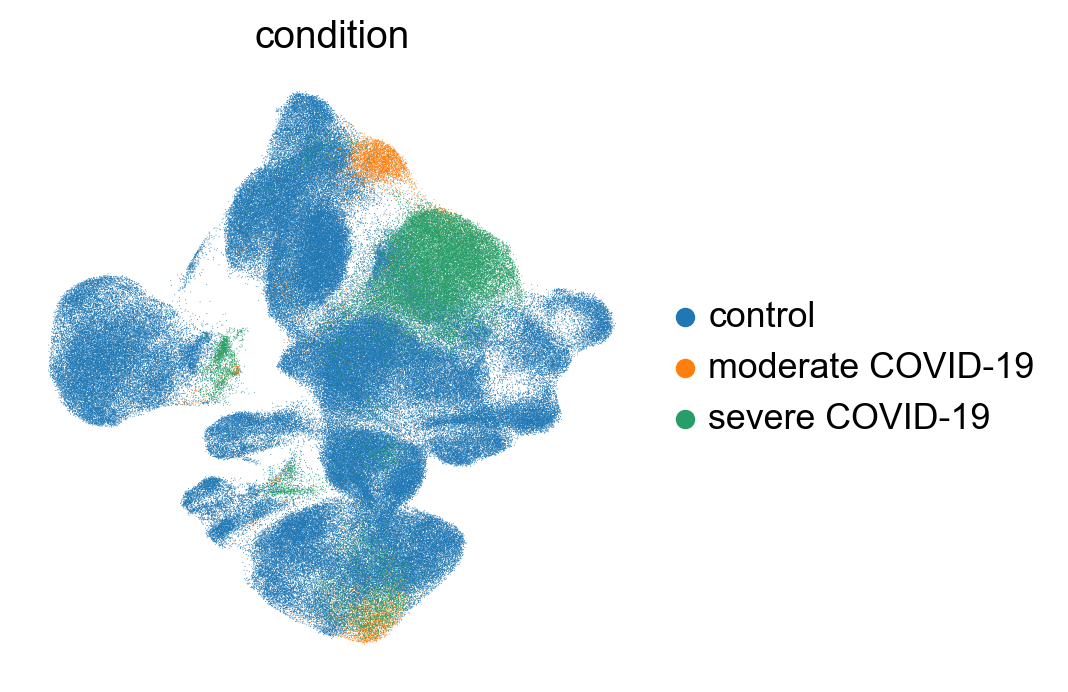

In [43]:
sc.pl.umap(adata, color=["condition"], frameon=False)

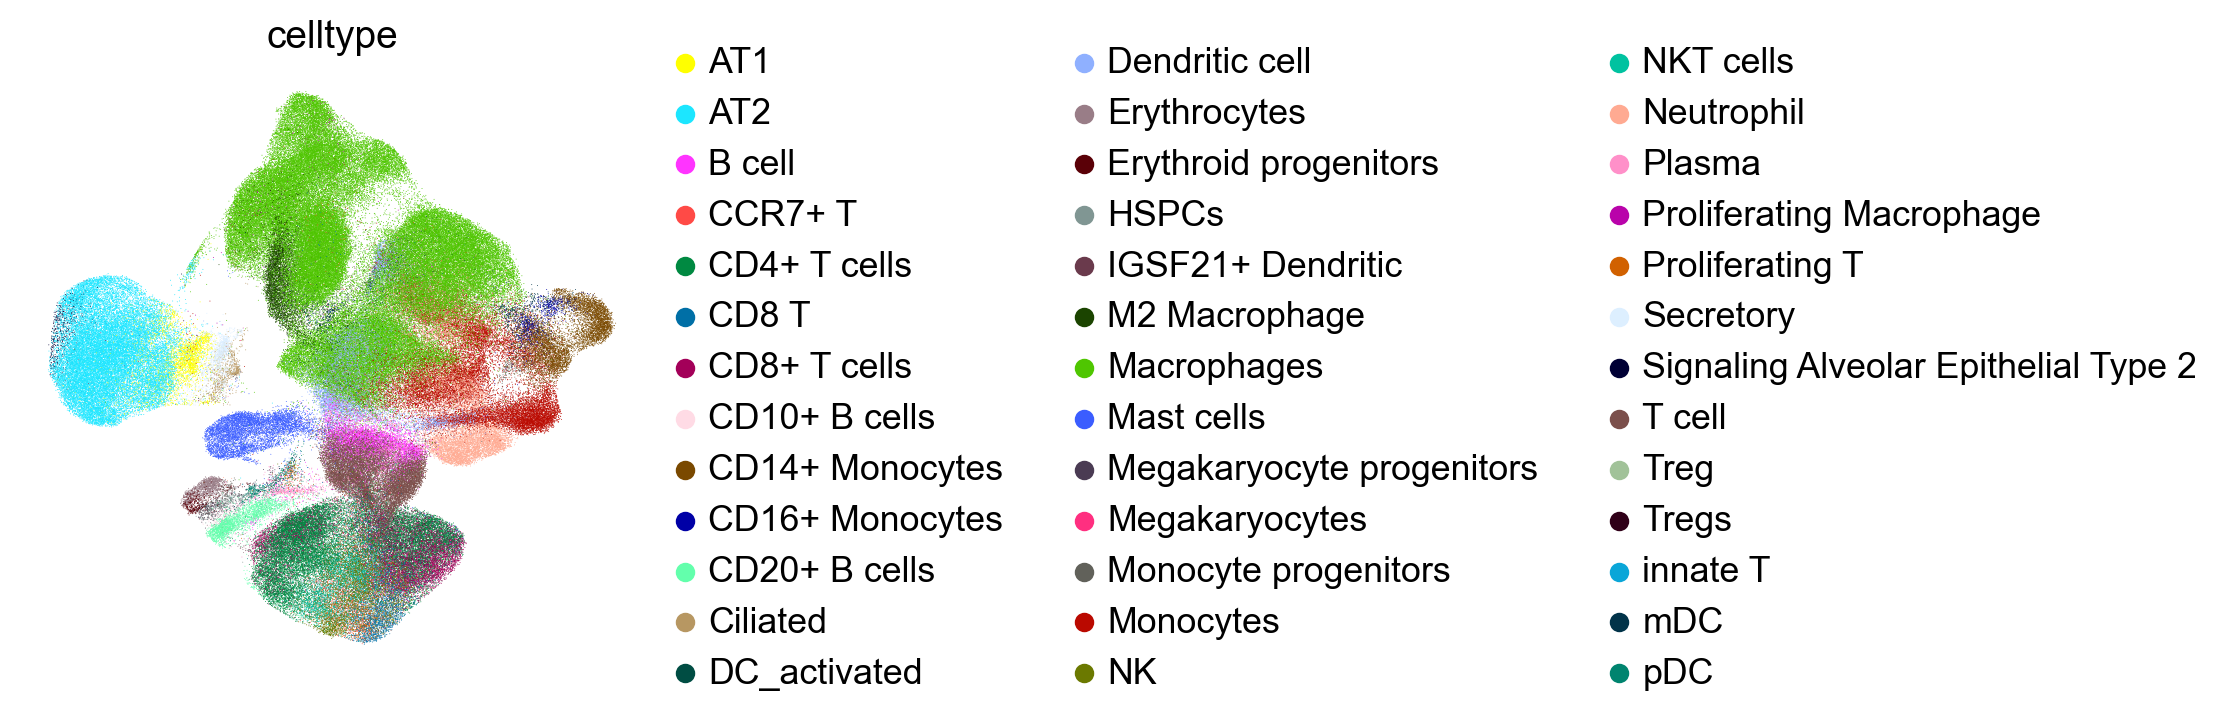

In [44]:
sc.pl.umap(adata, color=[cell_type_key], palette=sc.pl.palettes.godsnot_102, frameon=False)

In [45]:
adata.obs["celltype"].replace("NK cells","NK",inplace=True)

In [46]:
adata.obs["celltype"].replace("CD8 T","CD8+ T cells", inplace=True)

In [56]:
adata.write("./data/covid/covid_integrated_new_for_pub2.h5ad")